<a href="https://colab.research.google.com/github/jakechinmk/data_science/blob/main/give_me_credit/notebook/03_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
Feature engineering with Optimal Binning and then build model with logistic regression to understand what should be the baseline.

# Setup

In [ ]:
!pip install -q optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 8.1 MB/s eta 0:00:00


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from optbinning import BinningProcess, Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

from yellowbrick.classifier import ClassificationReport, ROCAUC 
from yellowbrick.classifier import PrecisionRecallCurve, DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import CVScores
from yellowbrick.model_selection import FeatureImportances

(CVXPY) Apr 26 02:02:33 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Apr 26 02:02:33 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


## Global Configuration

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/train_df.csv'
VALID_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/valid_df.csv'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/'
OUTPUT = True
SEED = 123
TEST_SIZE = 0.3

## Global Function

In [ ]:
def classifier_evaluation(model, x_train, y_train, x_test, y_test, cv, scoring):
  fig, axes = plt.subplots(3, 2, figsize=(10, 8))

  visualizer_list = [
      ClassificationReport(model, ax=axes[0][0]),
      ConfusionMatrix(model, ax=axes[0][1]),
      ROCAUC(model, ax=axes[1][0]),
      PrecisionRecallCurve(model, ax=axes[1][1]),
      DiscriminationThreshold(model, ax=axes[2][0]),
      CVScores(model, cv=cv, scoring=scoring, ax=axes[2][1])
  ]

  for i, viz in enumerate(visualizer_list):
    viz.fit(x_train, y_train)
    if i < 4:
      viz.score(x_test, y_test)
    viz.finalize()
  plt.show()

In [ ]:
def bucket_evaluation(y_pred_prob:np.ndarray, y_true:pd.Series, bucket:int) -> pd.DataFrame:
    """Evaluate model based on bucket defined

    Args:
        y_pred_prob (np.ndarray): probability predicted using model.
        y_true (pd.Series): true label
        bucket (int): number of bucket.

    Returns:
        pd.DataFrame: Aggregated performance. Similar like CAP graph
    """
    df = pd.DataFrame({
        'pred':y_pred_prob,
        'true':y_true
        })
    df.loc[:, 'bins'], limit = pd.qcut(df.loc[:, 'pred'], 
                                       q=bucket, 
                                       labels=range(1, bucket+1), 
                                       retbins=True
                                       )
    rename_dict = {'sum':'event',
                   'count':'total',
                   }
    agg_df = (df.groupby('bins', as_index=False)['true']
              .agg(['sum', 'count'])
              .rename(columns=rename_dict)
              )
    agg_df.loc[:, 'lower_limit'] = limit[:-1]
    agg_df.loc[:, 'upper_limit'] = limit[1:]
    agg_df.loc[:, 'cumulative_event'] = agg_df.loc[:, 'event'].cumsum()
    agg_df.loc[:, 'cumulative_total'] = agg_df.loc[:, 'total'].cumsum()
    agg_df.loc[:, 'capture_rate'] = (agg_df.loc[:, 'cumulative_event'] 
                                     / agg_df.loc[:, 'event'].sum()
                                     )
    agg_df.loc[:, 'event_rate'] = agg_df.loc[:, 'event'] / agg_df.loc[:, 'total']
    return agg_df

# Data
## Information from Data Dictionary
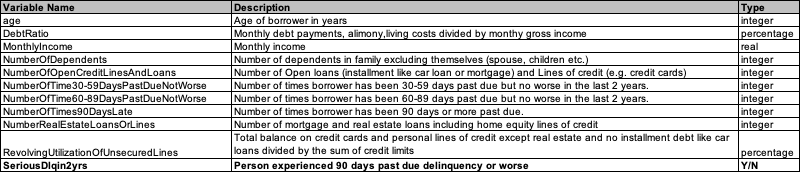

## Read Data

In [ ]:
train_df = pd.read_csv(TRAIN_PATH)
valid_df = pd.read_csv(VALID_PATH)

In [ ]:
target = 'serious_dlqin_2yrs'
feature_list = train_df.columns.drop(target).tolist()

## Split Dataset

In [ ]:
y = train_df.loc[:, target]
x = train_df.loc[:, feature_list]
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=SEED
                                                    )
x_valid = valid_df.copy(deep=True)

In [ ]:
display(x_train.shape, x_test.shape)

(105000, 10)

(45000, 10)

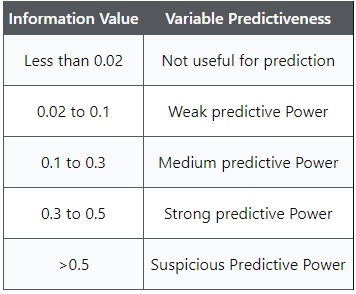

# Model

In [ ]:
selection_criteria = {
    'iv': {'min':0.02, 'max':1},
    'quality_score':{'min':0.01}
}

binning_process = BinningProcess(feature_list,
                                 selection_criteria=selection_criteria,
                                 )

model = LogisticRegression(solver='lbfgs', 
                           class_weight='balanced', 
                           random_state=SEED
                           )
pipeline = Pipeline(steps=[('binning_process', binning_process),
                           ('logistic_regression', model),
                           ])

pipeline.fit(x_train, y_train)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Model Performance Evaluation

In [ ]:
bin_df = binning_process.summary()
mask = bin_df.selected == True
bin_df.loc[mask, :].sort_values(by='iv', ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,number_of_times_90_days_late,numerical,OPTIMAL,True,2,0.798187,0.085144,0.30266,0.060769
2,number_of_time_30_59_days_past_due_not_worse,numerical,OPTIMAL,True,3,0.718946,0.082872,0.372145,0.201851
8,number_of_time_60_89_days_past_due_not_worse,numerical,OPTIMAL,True,2,0.548173,0.059703,0.234785,0.111133
1,age,numerical,OPTIMAL,True,11,0.254969,0.030877,0.265721,0.62012
3,debt_ratio,numerical,OPTIMAL,True,8,0.08389,0.010377,0.149926,0.250058
4,monthly_income,numerical,OPTIMAL,True,9,0.083249,0.010338,0.162791,0.1471
7,number_real_estate_loans_or_lines,numerical,OPTIMAL,True,4,0.050846,0.006342,0.116262,0.160954
9,number_of_dependents,numerical,OPTIMAL,True,4,0.034177,0.004261,0.096592,0.09781


Based on IV, we knew which is relatively important in this dataset on univariate basis.

## Feature Importance

In [ ]:
x_train_trans = binning_process.transform(x_train)
x_test_trans = binning_process.transform(x_test)
x_valid_trans = binning_process.transform(x_valid)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


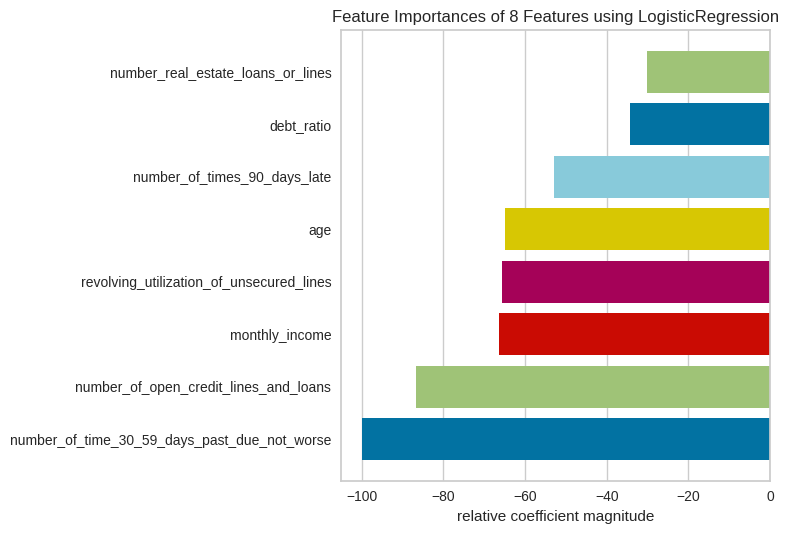

In [ ]:
viz = FeatureImportances(pipeline.get_params().get('steps')[1][1], relatives=False)
viz.fit(x_train, y_train)
viz.show()
plt.show()

In [ ]:
y_pred = pipeline.predict_proba(x_train)[:, 1]

## Train AUC

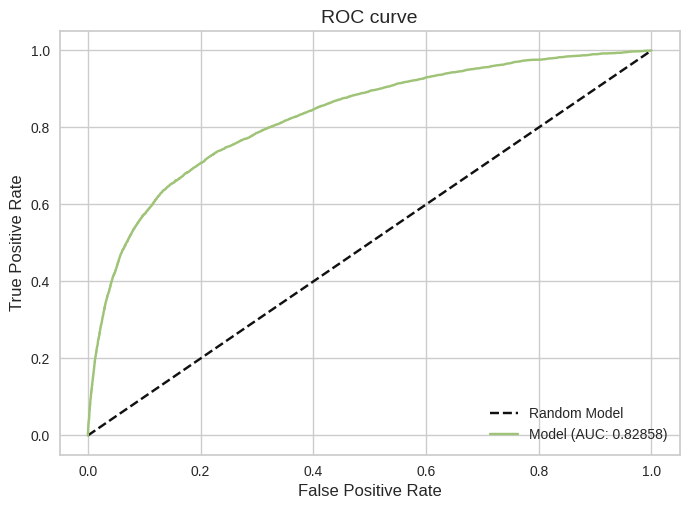

In [ ]:
plot_auc_roc(y_train, y_pred)

## Train CAP

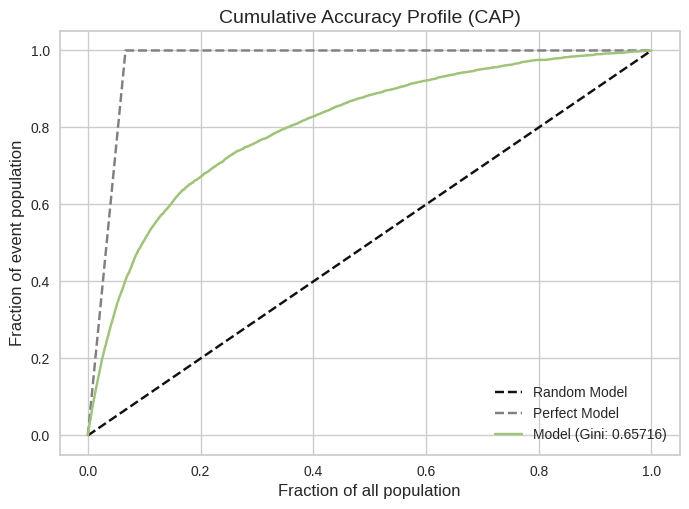

In [ ]:
plot_cap(y_train, y_pred)

## Train KS

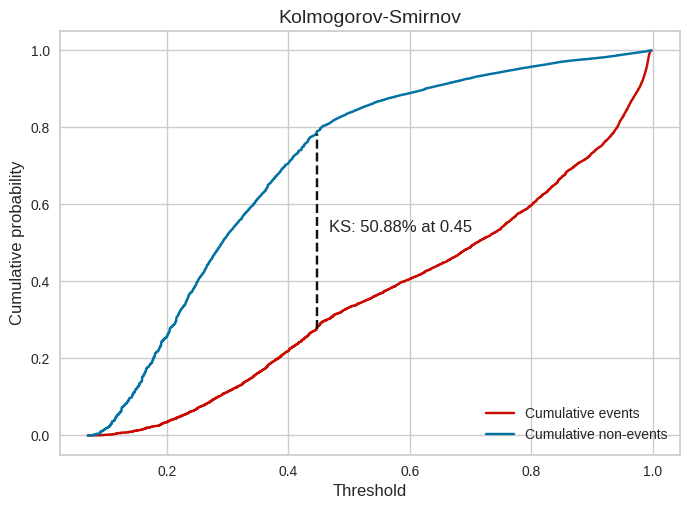

In [ ]:
plot_ks(y_train, y_pred)

## Summary on Train Performance
- AUC: 0.82
- Gini: 0.66
- Max KS (50.88) at threshold 0.45

## Bucket Evaluation on Train Data

In [ ]:
bucket_evaluation(y_pred_prob=y_pred, y_true=y_train, bucket=10)

,event,total,lower_limit,upper_limit,cumulative_event,cumulative_total,capture_rate,event_rate
bins,,,,,,,,
1,75,10505,0.070165,0.144278,75,10505,0.010684,0.007139
2,96,10495,0.144278,0.180591,171,21000,0.024359,0.009147
3,170,10506,0.180591,0.220564,341,31506,0.048575,0.016181
4,205,10494,0.220564,0.260669,546,42000,0.077778,0.019535
5,268,10527,0.260669,0.302963,814,52527,0.115954,0.025458
6,391,10490,0.302963,0.359217,1205,63017,0.171652,0.037274
7,466,10487,0.359217,0.414861,1671,73504,0.238034,0.044436
8,634,10513,0.414861,0.494676,2305,84017,0.328348,0.060306
9,1158,10484,0.494676,0.701837,3463,94501,0.493305,0.110454


## Conclusion on Bucket Evaluation on Train Data
Based on the theshold = 0.45, we can cover about 70% to 80% of the payers (bins no.8) where we only capture 23% to 32% of the bad payer.

## Bucket Evaluation on Test Data

In [ ]:
y_pred = pipeline.predict_proba(x_test)[:, 1]
bucket_evaluation(y_pred_prob=y_pred, y_true=y_test, bucket=10)

,event,total,lower_limit,upper_limit,cumulative_event,cumulative_total,capture_rate,event_rate
bins,,,,,,,,
1,28,4500,0.070165,0.144157,28,4500,0.009315,0.006222
2,47,4651,0.144157,0.180490,75,9151,0.024950,0.010105
3,48,4353,0.180490,0.219184,123,13504,0.040918,0.011027
4,89,4499,0.219184,0.259171,212,18003,0.070526,0.019782
5,111,4513,0.259171,0.301046,323,22516,0.107452,0.024596
6,143,4498,0.301046,0.356326,466,27014,0.155023,0.031792
7,184,4486,0.356326,0.412111,650,31500,0.216234,0.041016
8,273,4500,0.412111,0.493631,923,36000,0.307053,0.060667
9,477,4514,0.493631,0.700313,1400,40514,0.465735,0.105671


## Conclusion on Bucket Evaluation on Test Data
Based on the theshold = 0.45, we still can cover about 70% to 80% of the payers (bins no.8) where we only capture 21% to 30% of the bad payer.

It does not give huge difference though.

## Typical Metric Evaluation

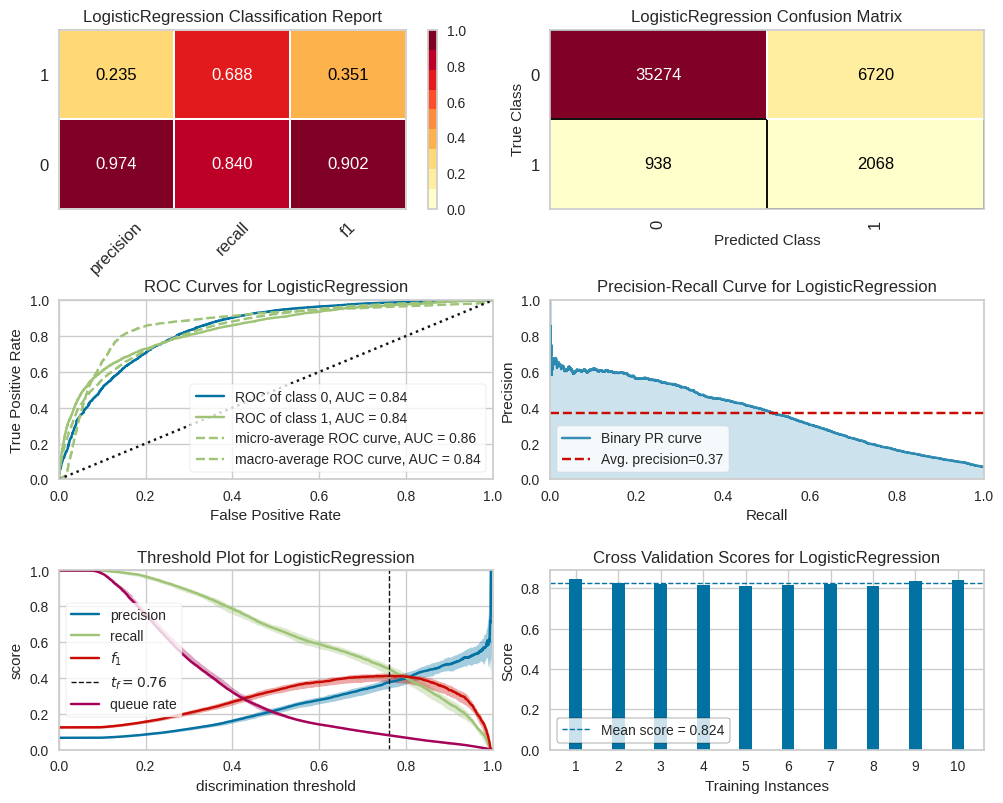

In [ ]:
classifier_evaluation(pipeline, x_train, y_train, x_test, y_test, cv, 'roc_auc')

## Summary
- AUC: 0.84 (difference between micro and macro is not that huge)
- Based on the confusion matrix, it's advised to calculate the potential profit that we are losing and potential loss we will incur.
- The discrimination theshold is about 0.76, which meant we should not offer any loan if it exceed 0.76, which in bucket evaluation it will be our last bin (bins no. 10)
- CV: 0.82 on average but more than 0.8 (stable performance as expected. Since Logistic Regression suppose to have less variance and more bias)

# Output

In [ ]:
if OUTPUT:
  train_df = pd.concat([x_train, y_train], axis=1)
  test_df = pd.concat([x_test, y_test], axis=1)

  train_df.to_csv(f'{OUTPUT_DIR}03-baseline_model-train_df.csv')
  test_df.to_csv(f'{OUTPUT_DIR}03-baseline_model-test_df.csv')

  joblib.dump(pipeline, f'{OUTPUT_DIR}03-baseline_model-pipeline.pkl')

# Recommendation
Based on various analysis (bucket evaluation, model performance evaluation)
- the final features selected are 
  - number of times 90 days late
  - number of time 30-59 days past due
  - number of time 60-89 days past due
  - age
  - debt_ratio
  - monthly_income
  - number_real_estate_loans_or_lines
  - number_of_dependents
- The model performance
  - are relatively stable although the test performance is higher than the train performance
  - is definitely suspicious for the features IV more than 0.5 whether it's a data leakage issue.
  - with threshold of 0.45, we can get about 70-80% of the existing population with lower risk, we can further divide the bucket into
      - lowest risk (bin 1-3) - higher loan amount and lower interest rate
      - moderate risk (bin 4-8) - normal loan amount and interest rate
      - high risk (bin 9) - lower loan amount and high interest rate
      - rejected (bin 10) since the threshold exceeded 0.76